## Imports
These are the imported packages for this session.

In [1]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

import os
import re

## Filtering

This script takes in a template image and a defective image, performs an xor operation between the two, then uses some basic morphology operations (open and erode) to clean the image and isolate the defects. Finally the contours of the image are found and drawn. They appear red in the final image.

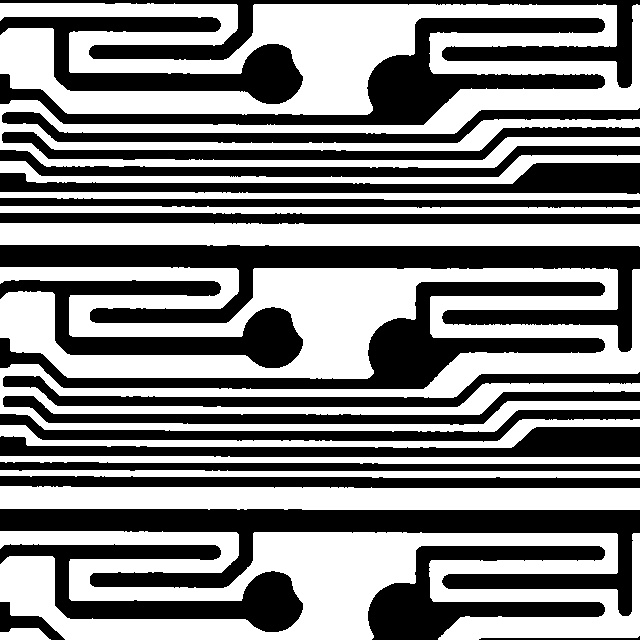

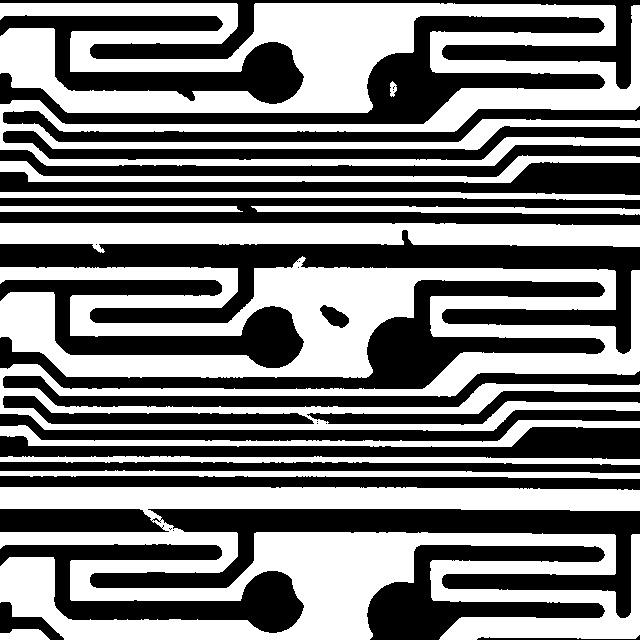

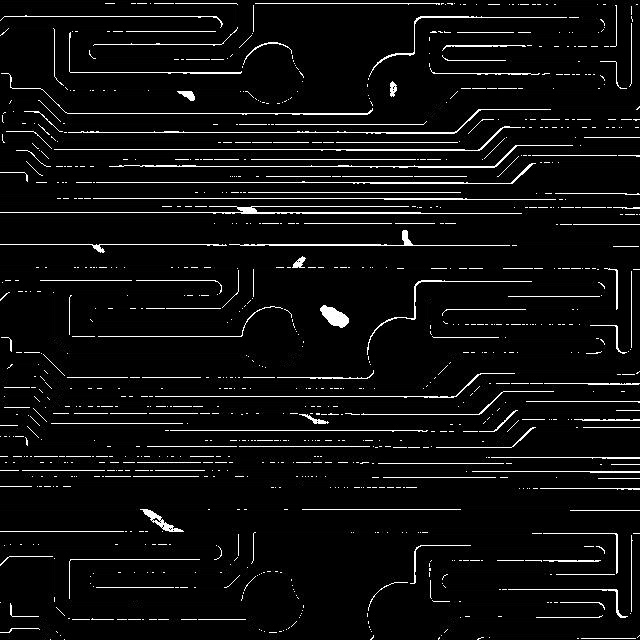

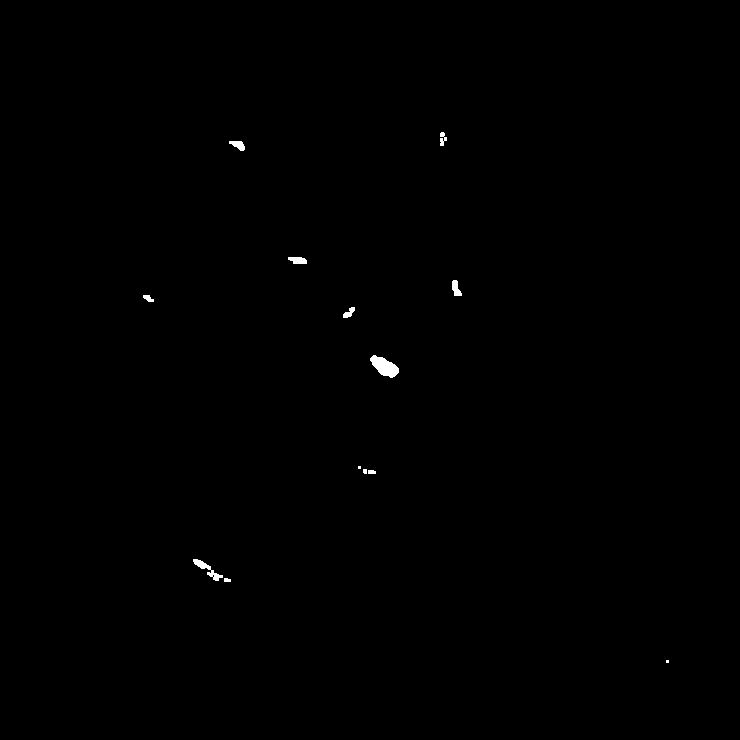

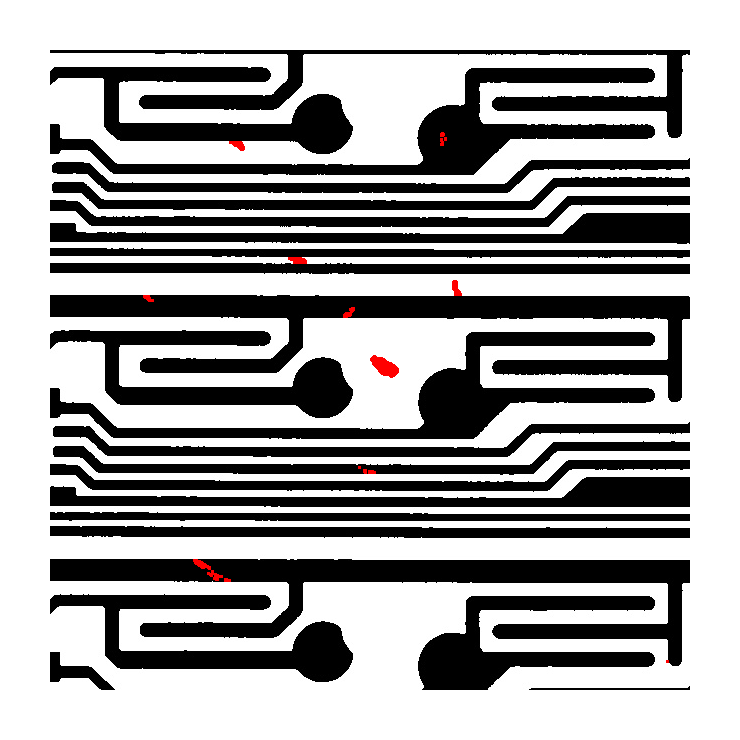

In [17]:
PADDING_WIDTH = 50
PADDING_HEIGHT = 50

im = cv.imread('/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000052_temp.jpg')
im2 = cv.imread('/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000052_test.jpg')

sub = cv.bitwise_xor(im, im2)

sub_expanded = cv.copyMakeBorder(sub, PADDING_HEIGHT, PADDING_HEIGHT, PADDING_WIDTH, PADDING_WIDTH, cv.BORDER_CONSTANT, value=0)

sub_filter = cv.morphologyEx(sub_expanded, cv.MORPH_OPEN, np.ones((3, 3)))

_, sub_thresh = cv.threshold(sub_filter, 127, 255, cv.THRESH_BINARY)

ref = cv.copyMakeBorder(im, PADDING_HEIGHT, PADDING_HEIGHT, PADDING_WIDTH, PADDING_WIDTH, cv.BORDER_CONSTANT, value=(255, 255, 255))
all_contours = cv.morphologyEx(sub_filter, cv.MORPH_ERODE, np.ones((9, 9)))
fresh_black = all_contours.copy()
fresh_ref = ref.copy()

imgray = cv.cvtColor(sub_thresh, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)

contours, hierarchy = cv.findContours(imgray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(ref, contours, -1, (0, 0, 255), -1)
cv.drawContours(all_contours, contours, -1, (255, 255, 255), -1)

cv2_imshow(im)
print("")
cv2_imshow(im2)
print("")
cv2_imshow(sub)
print("")
cv2_imshow(all_contours)
print("")
cv2_imshow(ref)

## Contour Clustering

Sometimes the contours don't perfectly fit all the errors, causing some extra contours to be left out. To solve this, we group together multiple contours with centroids close to one another. This way they will be drawn together and appear in the same image for training the model.

In [ ]:
FAR_ENOUGH_THRESHOLD = 25;

defect_list = []

for idx, contour in enumerate(contours):
  moment = cv.moments(contour)
  
  center_x = moment["m10"] / moment["m00"]
  center_y = moment["m01"] / moment["m00"]

  new_centroid = np.asarray((center_x, center_y))

  defect_list.append([[idx], [new_centroid]])

curr_idx = 0

while curr_idx < len(defect_list):
  curr_defect_group = defect_list[curr_idx]

  for curr_centroid in defect_list[curr_idx][1]:
    idx = curr_idx + 1

    while idx < len(defect_list):
      dist = np.sqrt(np.sum(np.square(defect_list[idx][1][0] - curr_centroid)))     

      if dist < FAR_ENOUGH_THRESHOLD:
        defect_list[curr_idx][0].append(defect_list[idx][0][0])
        defect_list[curr_idx][1].append(defect_list.pop(idx)[1][0])

      idx += 1

  curr_idx += 1

## Image Generation

Here each cluster of contours is centered by averaging out the centroids of each. Afterwards each contour cluster is drawn onto an image for ML training and an image for labeling. The ML training images contain white contours on a black background, while the context images have red contours printed onto sections of the template image for easy labeling. Note we may actually see better results using the context images in the model due to some more obvious patterns.

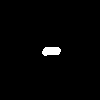

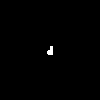

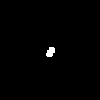

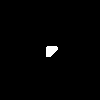

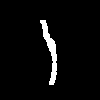

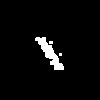

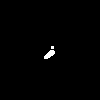

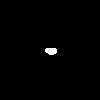

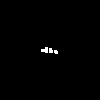

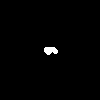

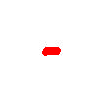

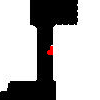

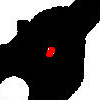

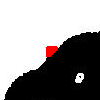

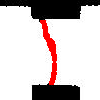

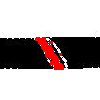

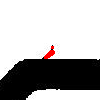

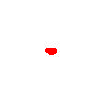

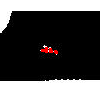

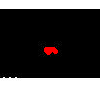

In [ ]:
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100

ml_defects = []
context_defects = []

for defect in defect_list:
  ml_image = fresh_black.copy()
  context_image = fresh_ref.copy()

  total_centroid = np.asarray((0.0, 0.0))

  for centroid in defect[1]:
    total_centroid += centroid

  for idx in defect[0]:
    cv.drawContours(ml_image, contours, idx, (255, 255, 255), -1)
    cv.drawContours(context_image, contours, idx, (0, 0, 255), -1)

  total_centroid /= len(defect[1])

  l_side_x = int(total_centroid[0] - IMAGE_WIDTH / 2)
  r_side_x = int(total_centroid[0] + IMAGE_WIDTH / 2)
  top_side_y = int(total_centroid[1] - IMAGE_HEIGHT / 2)
  bottom_side_y = int(total_centroid[1] + IMAGE_HEIGHT / 2)

  ml_defects.append(ml_image[top_side_y:bottom_side_y, l_side_x:r_side_x])
  context_defects.append(context_image[top_side_y:bottom_side_y, l_side_x:r_side_x])

for image in ml_defects:
  cv2_imshow(image)
  print("")
for image in context_defects:
  cv2_imshow(image)
  print("")

## One Big Function

This combines all the processing into one function so that it can be performed on multiple files in one run.

[107.90677966 482.67372881]
[479.01818182 456.79393939]
[264.41579254 354.94959207]
[235.58185404 328.28205128]
[477.15286624 347.35456476]
[565.7976351 284.8402654]
[350.58888889 263.47407407]
[166.73573574 161.68468468]
[444.17195767  39.47048176]
[508.117506    41.07673861]


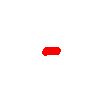

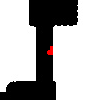

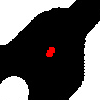

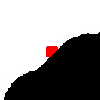

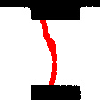

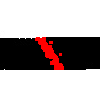

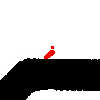

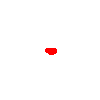

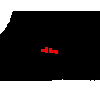

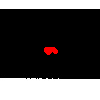

In [ ]:
def extract_contours(template, defective, \
                     padding_width = 50, \
                     padding_height = 50, \
                     far_enough_threshold = 25, \
                     image_width = 100, \
                     image_height = 100):
  
  PADDING_WIDTH = padding_width
  PADDING_HEIGHT = padding_height
  FAR_ENOUGH_THRESHOLD = far_enough_threshold;
  IMAGE_WIDTH = image_width
  IMAGE_HEIGHT = image_height

  im = cv.imread(template)
  im2 = cv.imread(defective)

  sub = cv.bitwise_xor(im, im2)

  sub_expanded = cv.copyMakeBorder(sub, PADDING_HEIGHT, PADDING_HEIGHT, PADDING_WIDTH, PADDING_WIDTH, cv.BORDER_CONSTANT, value=0)

  sub_filter = cv.morphologyEx(sub_expanded, cv.MORPH_OPEN, np.ones((3, 3)))

  _, sub_thresh = cv.threshold(sub_filter, 127, 255, cv.THRESH_BINARY)

  ref = cv.copyMakeBorder(im, PADDING_HEIGHT, PADDING_HEIGHT, PADDING_WIDTH, PADDING_WIDTH, cv.BORDER_CONSTANT, value=(255, 255, 255))
  all_contours = cv.morphologyEx(sub_filter, cv.MORPH_ERODE, np.ones((9, 9)))
  fresh_black = all_contours.copy()
  fresh_ref = ref.copy()

  imgray = cv.cvtColor(sub_thresh, cv.COLOR_BGR2GRAY)
  ret, thresh = cv.threshold(imgray, 127, 255, 0)

  contours, hierarchy = cv.findContours(imgray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  cv.drawContours(ref, contours, -1, (0, 0, 255), -1)
  cv.drawContours(all_contours, contours, -1, (255, 255, 255), -1)

  defect_list = []

  for idx, contour in enumerate(contours):
    moment = cv.moments(contour)
    
    center_x = moment["m10"] / moment["m00"]
    center_y = moment["m01"] / moment["m00"]

    new_centroid = np.asarray((center_x, center_y))

    defect_list.append([[idx], [new_centroid]])

  curr_idx = 0

  while curr_idx < len(defect_list):
    curr_defect_group = defect_list[curr_idx]

    for curr_centroid in defect_list[curr_idx][1]:
      idx = curr_idx + 1

      while idx < len(defect_list):
        dist = np.sqrt(np.sum(np.square(defect_list[idx][1][0] - curr_centroid)))     

        if dist < FAR_ENOUGH_THRESHOLD:
          defect_list[curr_idx][0].append(defect_list[idx][0][0])
          defect_list[curr_idx][1].append(defect_list.pop(idx)[1][0])

        idx += 1

    curr_idx += 1

  ml_defects = []
  context_defects = []

  for defect in defect_list:
    ml_image = fresh_black.copy()
    context_image = fresh_ref.copy()

    total_centroid = np.asarray((0.0, 0.0))

    for centroid in defect[1]:
      total_centroid += centroid

    for idx in defect[0]:
      cv.drawContours(ml_image, contours, idx, (255, 255, 255), -1)
      cv.drawContours(context_image, contours, idx, (0, 0, 255), -1)

    total_centroid /= len(defect[1])

    print(total_centroid - np.asarray((PADDING_WIDTH, PADDING_HEIGHT)))

    l_side_x = int(total_centroid[0] - IMAGE_WIDTH / 2)
    r_side_x = int(total_centroid[0] + IMAGE_WIDTH / 2)
    top_side_y = int(total_centroid[1] - IMAGE_HEIGHT / 2)
    bottom_side_y = int(total_centroid[1] + IMAGE_HEIGHT / 2)

    ml_defects.append(ml_image[top_side_y:bottom_side_y, l_side_x:r_side_x])
    context_defects.append(context_image[top_side_y:bottom_side_y, l_side_x:r_side_x])

  return ml_defects, context_defects

ml_defects, context_defects = extract_contours(\
        '/content/drive/MyDrive/ENEE439D Project/00041000_temp.jpg', \
        '/content/drive/MyDrive/ENEE439D Project/00041000_test.jpg')

#for image in ml_defects:
  #cv2_imshow(image)
  #print("")
for image in context_defects:
  cv2_imshow(image)
  print("")

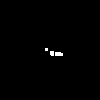

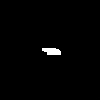

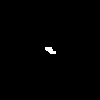

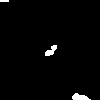

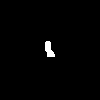

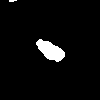

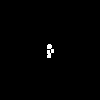

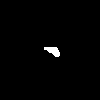

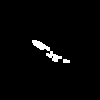

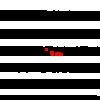

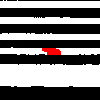

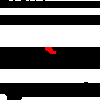

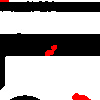

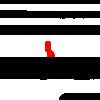

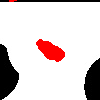

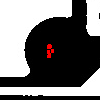

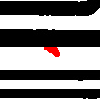

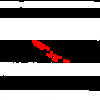

In [18]:
def gen_deepPCB_morphology_images(template, test, labelfile,\
                                  padding_width=50,\
                                  padding_height=50,\
                                  image_width=100,\
                                  image_height=100):
  PADDING_WIDTH = padding_width
  PADDING_HEIGHT = padding_height
  IMAGE_WIDTH = image_width
  IMAGE_HEIGHT = image_height

  im = cv.imread(template)
  im2 = cv.imread(test)

  sub = cv.bitwise_xor(im, im2)

  sub_expanded = cv.copyMakeBorder(sub, PADDING_HEIGHT, PADDING_HEIGHT, PADDING_WIDTH, PADDING_WIDTH, cv.BORDER_CONSTANT, value=0)

  sub_filter = cv.morphologyEx(sub_expanded, cv.MORPH_OPEN, np.ones((3, 3)))

  _, sub_thresh = cv.threshold(sub_filter, 127, 255, cv.THRESH_BINARY)

  context_image = cv.copyMakeBorder(im, PADDING_HEIGHT, PADDING_HEIGHT, PADDING_WIDTH, PADDING_WIDTH, cv.BORDER_CONSTANT, value=(255, 255, 255))
  ml_image = cv.morphologyEx(sub_filter, cv.MORPH_ERODE, np.ones((9, 9)))

  imgray = cv.cvtColor(sub_thresh, cv.COLOR_BGR2GRAY)
  ret, thresh = cv.threshold(imgray, 127, 255, 0)

  contours, hierarchy = cv.findContours(imgray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  cv.drawContours(context_image, contours, -1, (0, 0, 255), -1)
  cv.drawContours(ml_image, contours, -1, (255, 255, 255), -1)

  file = open(labelfile, "r")
  defect_lines = file.readlines()
  file.close()

  defect_info = [x.split(" ") for x in defect_lines]

  centers = [((int(x[0]) + int(x[2])) / 2 + PADDING_WIDTH, (int(x[1]) + int(x[3])) / 2 + PADDING_HEIGHT, x[4]) for x in defect_info]

  ml_defects = []
  context_defects = []

  for point in centers:
    l_side_x = int(point[0] - IMAGE_WIDTH / 2)
    r_side_x = int(point[0] + IMAGE_WIDTH / 2)
    top_side_y = int(point[1] - IMAGE_HEIGHT / 2)
    bottom_side_y = int(point[1] + IMAGE_HEIGHT / 2)

    ml_defects.append(ml_image[top_side_y:bottom_side_y, l_side_x:r_side_x])
    context_defects.append(context_image[top_side_y:bottom_side_y, l_side_x:r_side_x])

  return ml_defects, context_defects

ml_defects, context_defects = gen_deepPCB_morphology_images(\
        '/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000052_temp.jpg', \
        '/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000052_test.jpg', \
        '/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000_not/12000052.txt')

for image in ml_defects:
  cv2_imshow(image)
  print("")
for image in context_defects:
  cv2_imshow(image)
  print("")

1



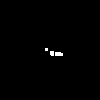

2



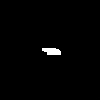

3



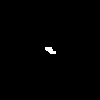

3



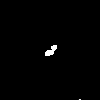

4



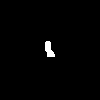

5



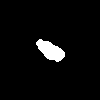

6



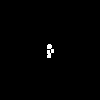

4



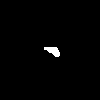

1



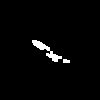

1



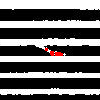

2



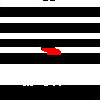

3



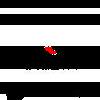

3



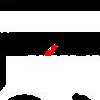

4



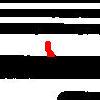

5



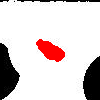

6



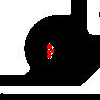

4



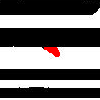

1



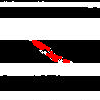

In [19]:
def extract_contours_again(template, defective, labelfile,\
                     padding_width = 50, \
                     padding_height = 50, \
                     far_enough_threshold = 25, \
                     image_width = 100, \
                     image_height = 100):
  
  PADDING_WIDTH = padding_width
  PADDING_HEIGHT = padding_height
  FAR_ENOUGH_THRESHOLD = far_enough_threshold;
  IMAGE_WIDTH = image_width
  IMAGE_HEIGHT = image_height

  im = cv.imread(template)
  im2 = cv.imread(defective)

  sub = cv.bitwise_xor(im, im2)

  sub_expanded = cv.copyMakeBorder(sub, PADDING_HEIGHT, PADDING_HEIGHT, PADDING_WIDTH, PADDING_WIDTH, cv.BORDER_CONSTANT, value=0)

  sub_filter = cv.morphologyEx(sub_expanded, cv.MORPH_OPEN, np.ones((3, 3)))

  _, sub_thresh = cv.threshold(sub_filter, 127, 255, cv.THRESH_BINARY)

  ref = cv.copyMakeBorder(im2, PADDING_HEIGHT, PADDING_HEIGHT, PADDING_WIDTH, PADDING_WIDTH, cv.BORDER_CONSTANT, value=(255, 255, 255))
  all_contours = cv.morphologyEx(sub_filter, cv.MORPH_ERODE, np.ones((9, 9)))
  fresh_black = all_contours.copy()
  fresh_ref = ref.copy()

  imgray = cv.cvtColor(sub_thresh, cv.COLOR_BGR2GRAY)
  ret, thresh = cv.threshold(imgray, 127, 255, 0)

  contours, hierarchy = cv.findContours(imgray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  defect_list = []
  
  file = open(labelfile, "r")
  label_lines = file.readlines()
  labels = [x.split(" ")[4] for x in label_lines]
  boxes = [x.split(" ")[0:4] for x in label_lines]

  defects = [(x, label, []) for x, label in enumerate(labels)]

  for idx, contour in enumerate(contours):
    moment = cv.moments(contour)
    
    center_x = moment["m10"] / moment["m00"]
    center_y = moment["m01"] / moment["m00"]

    for box_idx, box in enumerate(boxes):
      if center_x >= int(box[0]) + PADDING_WIDTH and center_x <= int(box[2]) + PADDING_WIDTH \
           and center_y >= int(box[1]) + PADDING_HEIGHT and center_y <= int(box[3]) + PADDING_HEIGHT:
        defects[box_idx][2].append(idx)

  ml_defects = []
  context_defects = []

  for defect_idx, defect in enumerate(defects):
    ml_image = fresh_black.copy()
    context_image = fresh_ref.copy()

    for idx in defect[2]:
      cv.drawContours(ml_image, contours, idx, (255, 255, 255), -1)
      cv.drawContours(context_image, contours, idx, (0, 0, 255), -1)

    box = boxes[defect_idx]
    
    x_center = (int(box[2]) + int(box[0])) / 2 + PADDING_WIDTH
    y_center = (int(box[3]) + int(box[1])) / 2 + PADDING_HEIGHT

    l_side_x = int(x_center - IMAGE_WIDTH / 2)
    r_side_x = int(x_center + IMAGE_WIDTH / 2)
    top_side_y = int(y_center - IMAGE_HEIGHT / 2)
    bottom_side_y = int(y_center + IMAGE_HEIGHT / 2)

    ml_defects.append((ml_image[top_side_y:bottom_side_y, l_side_x:r_side_x], labels[defect_idx]))
    context_defects.append((context_image[top_side_y:bottom_side_y, l_side_x:r_side_x], labels[defect_idx]))

  return ml_defects, context_defects

ml_defects, context_defects = extract_contours_again(\
        '/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000052_temp.jpg', \
        '/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000052_test.jpg', \
        '/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000_not/12000052.txt')

for defect in ml_defects:
  print(defect[1])
  cv2_imshow(defect[0])
for defect in context_defects:
  print(defect[1])
  cv2_imshow(defect[0])

## Creating the files
Run this script after running the imports and extract_contours_again methods

In [41]:
#groups = ["00041", "12000", "12100", "12300", "13000", "20085", "44000", "50600", "77000", "90100", "92000"]
groups = ["12000"]

DEEPPCB_PCBDATA_DIR = "/content/drive/MyDrive/ENEE439D Project/PCBData"
NEW_DATASET_DIR = "/content/drive/MyDrive/ENEE439D Project/GeneratedData"

if not os.path.exists(f"{NEW_DATASET_DIR}/Context_Images"):
  os.mkdir(f"{NEW_DATASET_DIR}/Context_Images")
if not os.path.exists(f"{NEW_DATASET_DIR}/Dark_Images"):
  os.mkdir(f"{NEW_DATASET_DIR}/Dark_Images")
if not os.path.exists(f"{NEW_DATASET_DIR}/Labels"):
  os.mkdir(f"{NEW_DATASET_DIR}/Labels")

for group in groups:
  label_names = os.listdir(f"{DEEPPCB_PCBDATA_DIR}/group{group}/{group}_not")
  labels = [f"{DEEPPCB_PCBDATA_DIR}/group{group}/{group}_not/{x}" for x in label_names]
  image_file_group = os.listdir(f"{DEEPPCB_PCBDATA_DIR}/group{group}/{group}")
  templates = []
  tests = []

  test_pattern = re.compile(".*test.*")

  number_pattern = re.compile(f".*{group}(\d\d\d)")

  for filename in image_file_group:
    if test_pattern.match(filename):
      tests.append(f"{DEEPPCB_PCBDATA_DIR}/group{group}/{group}/{filename}")
    else:
      templates.append(f"{DEEPPCB_PCBDATA_DIR}/group{group}/{group}/{filename}")

  templates.sort()
  tests.sort()
  labels.sort()

  if not os.path.exists(f"{NEW_DATASET_DIR}/Context_Images/{group}"):
    os.mkdir(f"{NEW_DATASET_DIR}/Context_Images/{group}")
  if not os.path.exists(f"{NEW_DATASET_DIR}/Dark_Images/{group}"):
    os.mkdir(f"{NEW_DATASET_DIR}/Dark_Images/{group}")

  files_len = len(labels)
  
  label_file = open(f"{NEW_DATASET_DIR}/Labels/{group}.txt", "w")

  for sample in range(files_len):
    dark, context = extract_contours_again(templates[sample], tests[sample], labels[sample], \
                  padding_width=112, padding_height=112, image_width=224, image_height=224)

    print(tests[sample])
    nums = number_pattern.match(tests[sample])[1]

    for idx, img in enumerate(dark):
      cv.imwrite(f"{NEW_DATASET_DIR}/Dark_Images/{group}/{group}{nums}-{idx}.jpg", img[0])

    for idx, img in enumerate(context):
      cv.imwrite(f"{NEW_DATASET_DIR}/Context_Images/{group}/{group}{nums}-{idx}.jpg", img[0])

    label_file.write(" ".join([x[1][0] for x in dark]))
    label_file.write("\n")

  label_file.close()    

/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000001_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000017_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000038_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000052_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000068_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000085_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000102_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000119_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000136_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000155_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000171_test.jpg
/content/drive/MyDrive/ENEE439D Project/PCBData/group12000/12000/12000187_test.jpg
/con